Remove the eclipsing binary signal using periodic rectangular window

In [1]:
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

Read the first time series

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
df = pd.read_csv("../data/sim_noisy_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

In [5]:
def plot_data(X, Y, X2=None, Y2=None):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Plot observations
    plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")
    if X2 is not None:
        plt.plot(X2, Y2, ".", mew=1, linewidth=1, mec="red")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])
    
def plot_lomb_scargle_periodogram(x, y, min_freq, max_freq, frequencies=None):
    if frequencies is not None:
        power = LombScargle(x, y).power(frequencies)
    else:
        frequencies, power = LombScargle(x, y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
    plt.figure(figsize=(35, 5))
    plt.plot(frequencies, power)
    plt.xlabel("frequency"), plt.ylabel("power")
    return frequencies, power

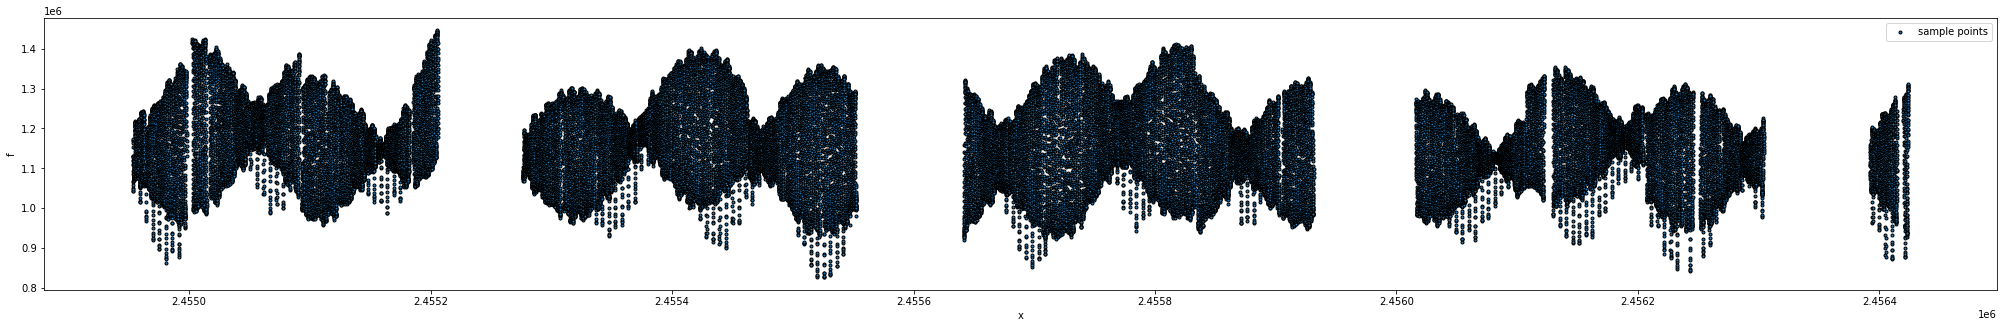

In [6]:
plot_data(X, Y)

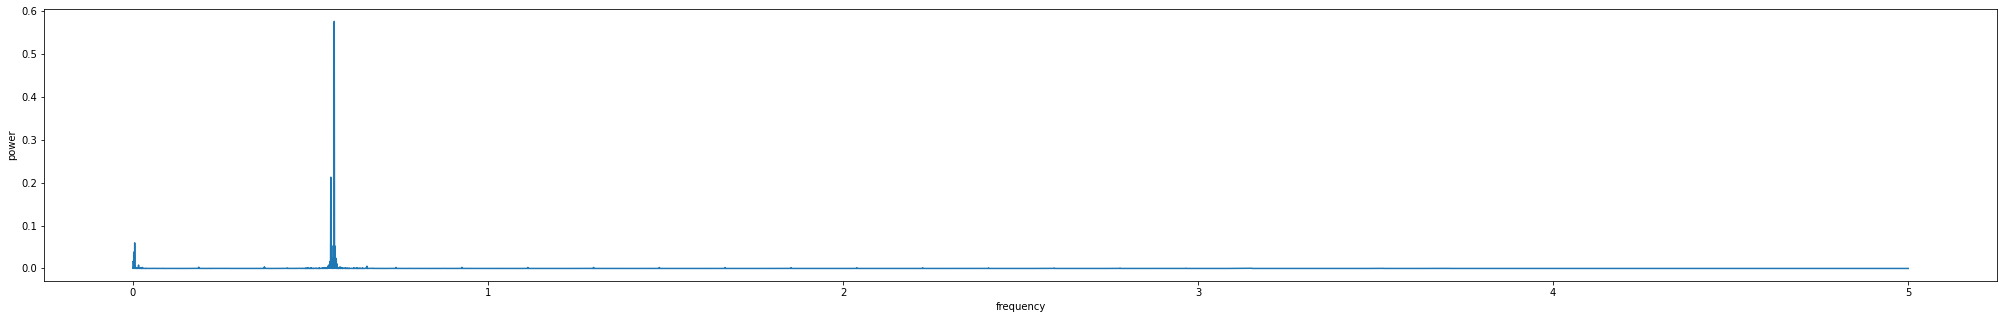

In [7]:
frequencies, power = plot_lomb_scargle_periodogram(X, Y, 0.0, 5)

In [8]:
# First envelope = 12000
N_part=12000 #X.shape[0]

In [9]:
X_part=X[:N_part]
Y_part=Y[:N_part]

In [10]:
plot_data(X_part, Y_part)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [11]:
X_part=torch.tensor(X_part)
Y_part=torch.tensor(Y_part)

In [12]:
# Predict evenly spaced points on our time-axis
X_part_smooth = torch.tensor(np.linspace(X_part.min(), X_part.max(), N_part))

In [13]:
def find_nearest_idx(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

0.020434249192476273


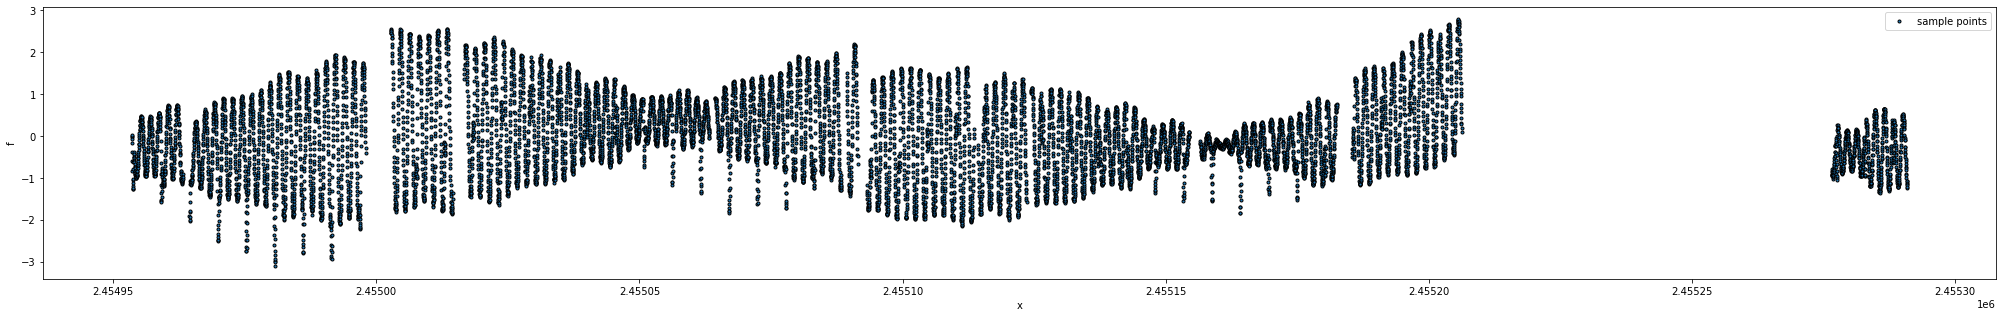

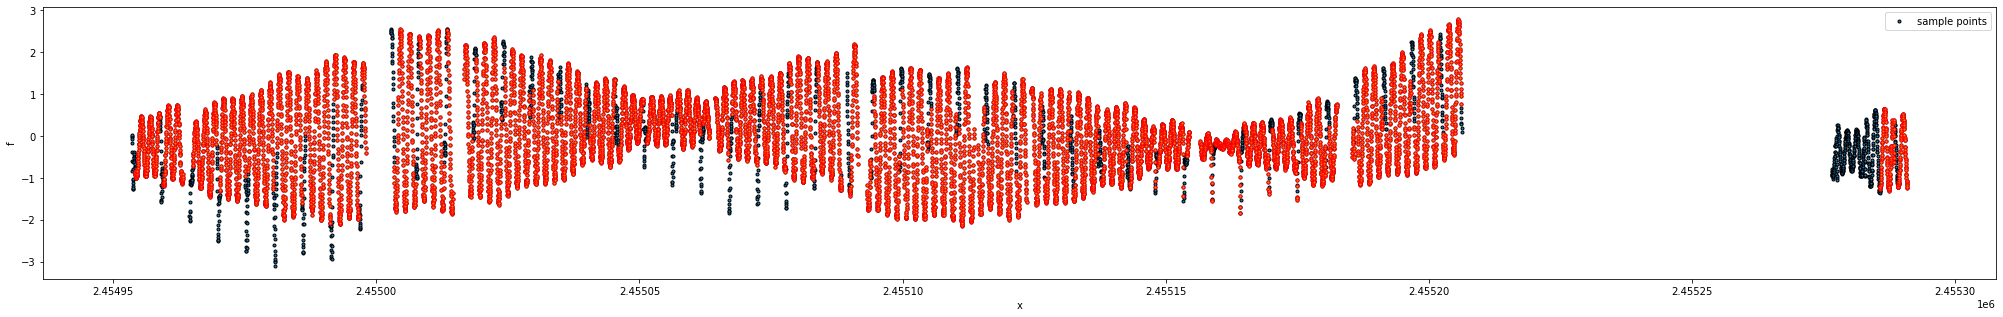

In [24]:
eclipse_x = -4
first_eclipse_date = X_part[0]
sample_period = X[1] - X[0]
print(sample_period)
first_eclipse_date = first_eclipse_date + eclipse_x * sample_period
window_size = 30  # todo: window size in dates?
period=5.402838838247893
X_part_window = X_part.clone().detach()
Y_part_window = Y_part.clone().detach()

# Find the next eclipse. Loop over dates here, as the positions in the array will change when we start deleting windows
next_eclipse_date = first_eclipse_date

while next_eclipse_date < X_part.max():
    next_eclipse_x = find_nearest_idx(X_part_window, next_eclipse_date).item()
    # Now delete the window
#    i = { "left" : max(int(next_eclipse_x-window_size/2), 0), "right": int(next_eclipse_x+window_size/2)}
    i = { "left" : max(int(next_eclipse_x), 0), "right": max(int(next_eclipse_x+window_size), 0)}
    X_part_window = torch.cat((X_part_window[:i['left']], X_part_window[i['right']:]))
    Y_part_window = torch.cat((Y_part_window[:i['left']], Y_part_window[i['right']:]))
    next_eclipse_date += period

plot_data(X_part, Y_part)
plot_data(X_part, Y_part, X_part_window, Y_part_window)


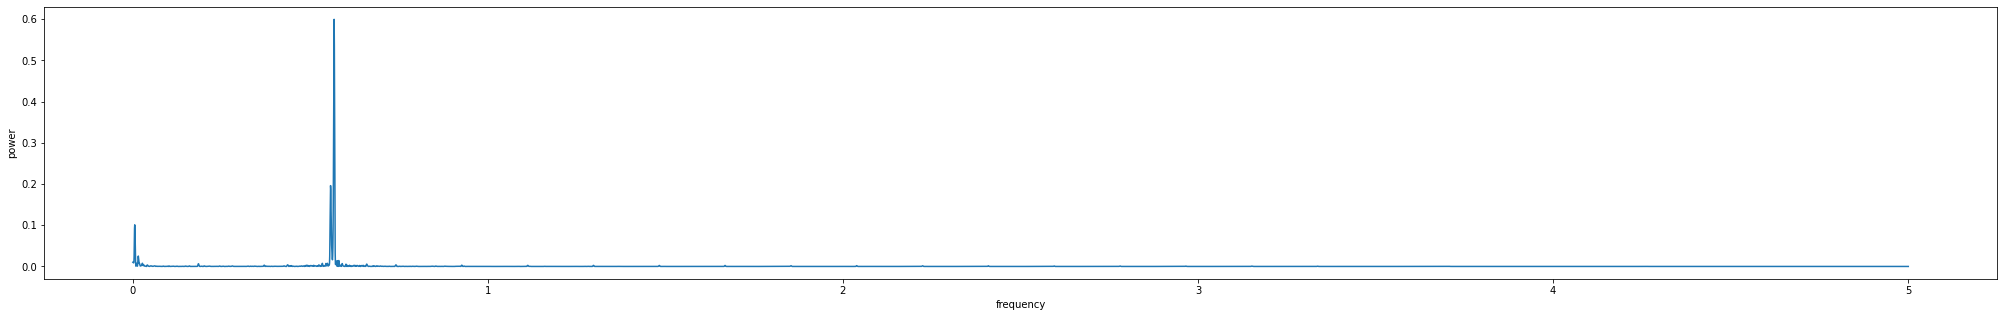

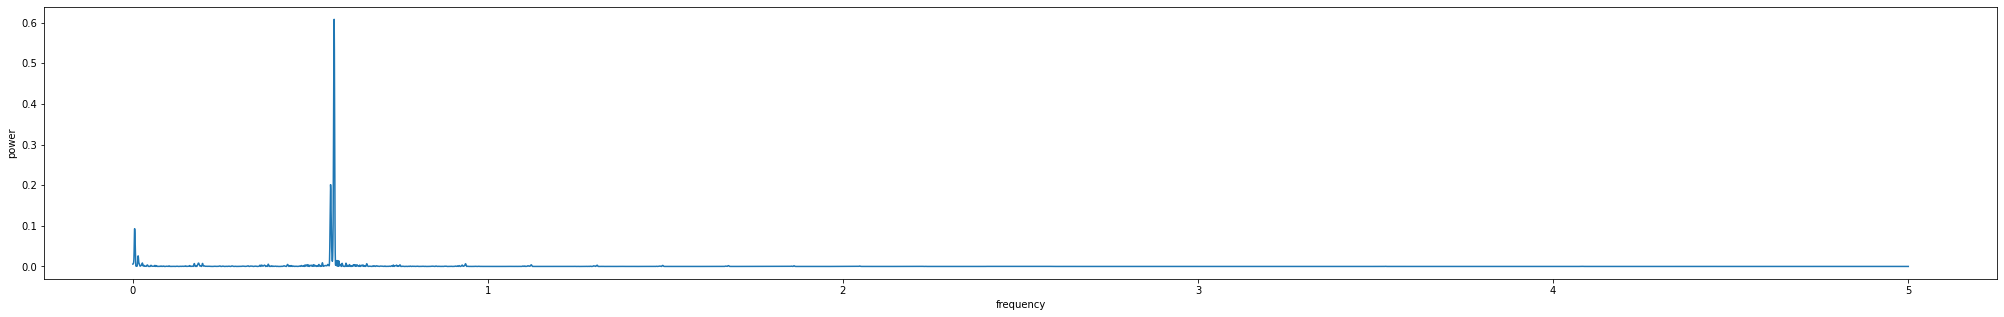

In [15]:
frequencies, power = plot_lomb_scargle_periodogram(X_part, Y_part, 0.0, 5)
frequencies, power = plot_lomb_scargle_periodogram(X_part_window, Y_part_window, 0.0, 5)

In [16]:
def normalize(series):
   mean, std = series.mean(),series.std()
   series = (series - mean) / std
   return mean, std, series

In [17]:
# !! It's important that we normalize *after* removing the E.B. signal, as that E.B. signal has a major impact on the mean
# In other words, if we normalize first, then remove the E.B., the remaining signal will be somewhere centered around +0.2
# We can not fit any kernel (RBF, Matern...) to a non-normalized signal!!
# normalize labels
mean, std = Y_part_window.mean(),Y_part_window.std()
mean, std, Y_part_window = normalize(Y_part_window)
_, _, Y_part = normalize(Y_part)